# Prospecção de Dados (Data Mining) DI/FCUL - HA2

## Second Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP: `02`

* João Martins, 62532 - Hours worked on the project: 16
* Rúben Torres, 62531 - Hours worked on the project: 16
* Nuno Pereira, 56933 - Hours worked on the project: 16

## Objectives
The purpose of this Home Assignment is:

1. Analyze the itemset/rules generation procedure
2. Process and identify the most relevant rules

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

### 1. Read the Dataset

Dataset: Instacart [Market Basket Analysis](https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis)

The purpose of this Home Assignment is:

1. Analyze the itemset/rules generation procedure
2. Identify the most relevant rules

Please download the HA files from this moodle folder and inspect it like this:

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

The dataset has been preprocessed with transactions as lists of integers. It is necessary a decoder to see the actual products bought together

Uncompress the data set (zip file) which will produce 2 files:
* `order_products.pickle` a Python pickle with all the trasactions
* A `products.txt` - decoder table with all the data relative to each item

In [1]:
#Read product names and IDs
lines=open("products.txt", "rt", encoding="utf8").readlines()
products=[0]*len(lines)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid)]=pname
    
#read transactions
import pickle
orders=pickle.load(open("order_products.pickle", "rb"))

#check names of products on transaction 2 (example):
print("Transaction 2 is", orders[2])
for prod in orders[2]: print("Code: %5d is product: %s" %(prod, products[prod]))

Transaction 2 is [33120, 28985, 9327, 45918, 30035, 17794, 40141, 1819, 43668]
Code: 33120 is product: Organic Egg Whites
Code: 28985 is product: Michigan Organic Kale
Code:  9327 is product: Garlic Powder
Code: 45918 is product: Coconut Butter
Code: 30035 is product: Natural Sweetener
Code: 17794 is product: Carrots
Code: 40141 is product: Original Unflavored Gelatine Mix
Code:  1819 is product: All Natural No Stir Creamy Almond Butter
Code: 43668 is product: Classic Blend Cole Slaw


### Objective 1 - Analyze the itemset/rules generation procedure

1. From the approaches used in classes make a performance analysis up to a threshold level of support
2. Define a good support threshold for analysis according to your computational capabilities


In [2]:
### Add supporting functions here
from scipy.sparse import csr_matrix
from IPython.display import display_html
from itertools import chain,cycle

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth
from pyfim import pyeclat
from PD_freqitems import freqitemsets

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time


def display_side_by_side(*args,titles=cycle([''])) -> None:
    html_str: str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

def plot_execution_time(Dict: dict) -> None:
    plt.plot(np.log(Dict["num_itemsets"]), np.log(Dict["apriori"]), c="r", label="apriori")
    plt.plot(np.log(Dict["num_itemsets"]), np.log(Dict["FP-growth"]), c="k", label="fp-growth")
    plt.plot(np.log(Dict["num_itemsets"]), np.log(Dict["ECLAT"]), c="g", label="eclat")
    plt.plot(np.log(Dict["num_itemsets"]), np.log(Dict["PD"]), c="b", label="PD")
    plt.grid()
    plt.legend()
    plt.show()

def compute_binary_encoder(products, orders) -> pd:
    tr_enc = TransactionEncoder()
    trans_array = tr_enc.fit_transform(orders.values(), sparse=True)
    trans_array = csr_matrix(trans_array, shape=(len(orders.values()), len(tr_enc.columns_)))

    products_list = []
    for i in range(len(tr_enc.columns_)+1):
        products_list.append(products[i])

    products_list.pop(0)
    return pd.DataFrame.sparse.from_spmatrix(trans_array, columns=products_list)


################################################################
# Compute binary database
def test_minimum_support(binary_database: pd, Dict: dict) -> dict:
    for min_supp in Dict["threshold"]:
        t0 = time.time()
        FI_apriori=apriori(binary_database, min_supp)
        t1 = time.time()
        
        Dict["num_itemsets"].append(FI_apriori.shape[0])
        Dict["apriori"].append(t1-t0)

        FI_fpg= fpgrowth(binary_database, min_supp)
        t2 = time.time()

        Dict["FP-growth"].append(t2-t1)

        FI_eclat= pyeclat(orders.values(), min_supp)
        t3 = time.time()
        Dict["ECLAT"].append(t3-t2)

        FI_pdfis= freqitemsets(orders.values(), min_supp)
        t4 = time.time()
        Dict["PD"].append(t4-t3)

        print(min_supp, FI_apriori.shape[0],"\n\tApriori time:", t1-t0,
                                            "\n\tFP-growth time:", t2-t1,
                                            "\n\tECLAT time:", t3-t2,
                                            "\n\tPD time:", t4-t3)
    return Dict

########################################################################################################
# MemoryError: Unable to allocate 149. GiB for an array with shape (3214874, 49677) and data type bool #
########################################################################################################

# binary_database = compute_binary_encoder(products, orders)
# binary_database 

C:\Users\joaom\AppData\Local\Temp\ipykernel_392\2457405324.py:45: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  return pd.DataFrame.sparse.from_spmatrix(trans_array, columns=products_list)


0.09 2 
	Apriori time: 1.0022704601287842 
	FP-growth time: 8.981173515319824 
	ECLAT time: 39.677727460861206 
	PD time: 23.55022931098938
0.05 6 
	Apriori time: 1.280991554260254 
	FP-growth time: 9.634338855743408 
	ECLAT time: 43.815556049346924 
	PD time: 21.12587070465088
0.02 39 
	Apriori time: 12.730013608932495 
	FP-growth time: 14.522175073623657 
	ECLAT time: 48.61154222488403 
	PD time: 29.91963005065918
0.015 69 
	Apriori time: 97.73096895217896 
	FP-growth time: 25.131787300109863 
	ECLAT time: 54.619017601013184 
	PD time: 40.5562584400177
0.011 105 
	Apriori time: 494.3822841644287 
	FP-growth time: 33.14023685455322 
	ECLAT time: 61.077701807022095 
	PD time: 50.90965223312378


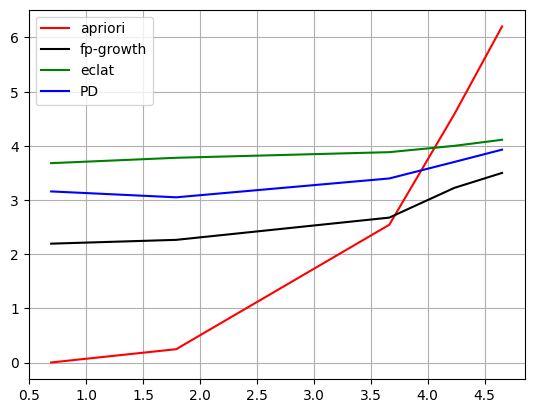

In [3]:
### Add processing code here
### 20min execution

MIN_SUPP = 0.011
binary_database = compute_binary_encoder(products, orders)

FI_apriori = apriori(binary_database, min_support=MIN_SUPP, use_colnames=False)
FI_apriori_len = FI_apriori.copy()

FI_apriori_len['length'] = FI_apriori_len['itemsets'].apply(lambda x: len(x))
FI_apriori_len = FI_apriori_len.sort_values(by=['length'], ascending=False)


FI_fpg = fpgrowth(binary_database, min_support=MIN_SUPP, use_colnames=False)
FI_fpg

FI_fpg['length'] = FI_fpg['itemsets'].apply(lambda x: len(x))
FI_fpg.sort_values(by=['length'], ascending=False)

# FI_FI_fpg_filtered = FI_fpg[(FI_fpg['support'] >= 0.01) & (FI_fpg['length'] >= 2)]
# FI_FI_fpg_filtered

FI_eclat = pyeclat(orders.values(), supp=MIN_SUPP)
FI_eclat


# display_side_by_side(FI_apriori, FI_fpg)



#WARNING! 0.01 sometimes crashes my computer it may well crash yours!
Dict={"threshold": [0.09, 0.05, 0.02, 0.015, 0.011], # 0.01
"num_itemsets": [],
"apriori":[],
"FP-growth": [],
"ECLAT": [],
"PD": []}

Dict = test_minimum_support(binary_database, Dict)

df_performance=pd.DataFrame(Dict)
df_performance

plot_execution_time(Dict)

### Your short analysis here

We analyzed 4 different algorithms:
- Apriori
- FP-growth
- ECLAT
- PD

Taking a look at the first table, we can observe that Apriori works best when the `minimum_support` is still relatively high [0.09, 0.02] (The lower our `minimum_support` goes the larger is the number of itemsets). However, FP-growth starts becoming a very attractive option when our `minimum_support` gets lower [0.02, 0.011]. The remaining algorithms grow more or less the same way to the FP-growth.

Next we have a graph (in logarithmic scale) where:
- Y: Time
- X: Number of Itemsets

As we can see in the graph, Apriori is useful when the number of itemsets is low (becomes unusable as we increase the number of itemsets). All the remaining algorithms behave really good when we have a lot of item sets (and not so good, when we have a low number of item sets).

For best results:
- Use Apriori when using high `minimum_support` (low number of itemsets)
- Use FP-growth when using low `minimum_support` (high number of itemsets)

### Objective 2 - Identify the most relevant rules

1. From your predefined support level generate all available itemsets and generate rules
2. Identify a set of 10 relevant rules using the Highest Lift criterion
    * **NOTE**: Present the rules with the product names and not as Integers 
3. Identify the Maximal and Closed Itemsets for the same level of support and generate 5 rules using the Highest Lift
    * **NOTE**: Do not list the Maximal or Closed Itemsets. Present just a few as an example and mention **how many** Closed and Maximal Itemsets were found for the selected support level
    * **NOTE**: Present the rules with the product names and not as Integers 


In [6]:
### Add supporting functions here

from mlxtend.frequent_patterns import association_rules, fpmax



In [8]:
### Add processing code here

# 1. From your predefined support level generate all available itemsets and generate rules

# available itemsets
available_itemsets = fpgrowth(binary_database, min_support=MIN_SUPP, use_colnames=False)
available_itemsets

available_itemsets['length'] = available_itemsets['itemsets'].apply(lambda x: len(x))
available_itemsets.sort_values(by=['length'], ascending=False)

# rules 
all_rules = association_rules(df=available_itemsets, metric="lift", min_threshold=0.05)
# print(FI_growth_rules)


# 2. Identify a set of 10 relevant rules using the Highest Lift criterion
#    * **NOTE**: Present the rules with the product names and not as Integers 
relevant_rules_lift = all_rules.sort_values(by='lift', ascending=False).head(10)
# print(relevant_rules_lift)


# 3. Identify the Maximal and Closed Itemsets for the same level of support and generate 5 rules using the Highest Lift
#    * **NOTE**: Do not list the Maximal or Closed Itemsets. Present just a few as an example and mention **how many** Closed and Maximal Itemsets were found for the selected support level
#    * **NOTE**: Present the rules with the product names and not as Integers 

#trs = transactions
closed_itemset = pyeclat(trs=orders.values(), supp=0.04, target="c")    
print("Number of Closed Itemsets", len(closed_itemset))
# print(closed_itemsets)

maximal_itemset = pyeclat(trs=orders.values(), supp=0.04, target="m")    
print("Number of maximal Itemsets", len(closed_itemset))


FI_fpmax = fpmax(binary_database, min_support=0.01, use_colnames=True)
max_itemsets = FI_fpmax.sort_values(by='conf', ascending=False).head(10)
print(FI_fpmax)

display_side_by_side(all_rules, relevant_rules_lift, maximal_itemset, closed_itemset)



Number of Closed Itemsets 11
Number of maximal Itemsets 11
[frozenset({24848, 16793})]

[frozenset({17790}), frozenset({28979}), frozenset({46656}), frozenset({24834}), frozenset({23905}), frozenset({31500}), frozenset({49224}), frozenset({4602}), frozenset({31711}), frozenset({27151}), frozenset({33192}), frozenset({195}), frozenset({27839}), frozenset({45057}), frozenset({19656}), frozenset({44623}), frozenset({46968}), frozenset({34963}), frozenset({42257}), frozenset({8514}), frozenset({35945}), frozenset({25885}), frozenset({41942}), frozenset({21934}), frozenset({22821}), frozenset({43344}), frozenset({22931}), frozenset({4917}), frozenset({49671}), frozenset({28193}), frozenset({28198}), frozenset({48668}), frozenset({27339}), frozenset({5074}), frozenset({39267}), frozenset({4796}), frozenset({5873}), frozenset({40698}), frozenset({37639}), frozenset({30385}), frozenset({11516}), frozenset({42728}), frozenset({24960}), frozenset({9072}), frozenset({19053}), frozenset({43114}), 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(24848),(21899),0.146993,0.075251,0.015987,0.108758,1.445272,0.004925,1.037596,0.361180
1,(21899),(24848),0.075251,0.146993,0.015987,0.212445,1.445272,0.004925,1.083108,0.333159
2,(21899),(21133),0.075251,0.082331,0.011862,0.157630,1.914594,0.005666,1.089390,0.516568
3,(21133),(21899),0.082331,0.075251,0.011862,0.144074,1.914594,0.005666,1.080408,0.520554
4,(21899),(13172),0.075251,0.118030,0.015668,0.208217,1.764107,0.006787,1.113904,0.468388
5,(13172),(21899),0.118030,0.075251,0.015668,0.132750,1.764107,0.006787,1.066301,0.491106
6,(13172),(47198),0.118030,0.066436,0.019391,0.164293,2.472945,0.011550,1.117095,0.675333
7,(47198),(13172),0.066436,0.118030,0.019391,0.291880,2.472945,0.011550,1.245511,0.638011
8,(21133),(47198),0.082331,0.066436,0.012689,0.154124,2.319880,0.007219,1.103665,0.619987
9,(47198),(21133),0.066436,0.082331,0.012689,0.190997,2.319880,0.007219,1.134322,0.609431


In [15]:
support_threshold = 0.01

# Find all frequent itemsets using FP-growth
frequent_itemsets_fp = fpgrowth(binary_database, min_support=support_threshold, use_colnames=True)

# Find maximal itemsets
maximal_itemsets = association_rules(frequent_itemsets_fp, metric="confidence", min_threshold=support_threshold, support_only=False)
maximal_itemsets = maximal_itemsets[maximal_itemsets['confidence'] == maximal_itemsets['confidence'].max()]

# Find closed itemsets
closed_itemsets = frequent_itemsets_fp.copy()
closed_itemsets = closed_itemsets[closed_itemsets['confidence'] == closed_itemsets['confidence'].max()]

# Number of maximal and closed itemsets
num_maximal_itemsets = len(maximal_itemsets)
num_closed_itemsets = len(closed_itemsets)

display_side_by_side(maximal_itemsets, closed_itemsets)
print(num_maximal_itemsets)
print(num_closed_itemsets)


antecedents 
 consequents 
 antecedent support 
 consequent support 
 support 
 confidence 
 lift 
 leverage 
 conviction 
 zhangs_metric 
 
 
 
 
 6 
 (Beef Ramen Noodle Soup) 
 (Rotelle) 
 0.118030 
 0.066436 
 0.019391 
 0.164293 
 2.472945 
 0.01155 
 1.117095 
 0.675333 
 
 
 7 
 (Rotelle) 
 (Beef Ramen Noodle Soup) 
 0.066436 
 0.118030 
 0.019391 
 0.291880 
 2.472945 
 0.01155 
 1.245511 
 0.638011 
 
 
 
 
 
 
 support 
 itemsets 
 
 
 
 
 22 
 0.146993 
 (Cheese & Fresh Herb Flatbread Pizza)

2
1


### Your short analysis here

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum
